# Episode 03 b: Puzzle

focus on puzzle

Checking the board visually is fine for debugging but it does not work well when it comes to test a lot of board solutions.

This episode provides some utilities for the POC to come. The goal is to have reasonably efficient classes but not spend too much time on this step.

**Goals for this episode:**
- Answer recurring questions 
    - What are the width, height, nulber of cellss of the puzzle 
    - Given a board is it completed ? 
    - Does it break the clues ?
    - Are they cells left undefined ? 
    - Am I close to the goal ?


# 1. Elements from episodes 01, 02 and 03

In [1]:
from episode01 import clues2x2, clues5x5s, Board, BoardMark
from episode02 import solution2x2, solution5x5s, GameEngine
from episode03a import BoardPlotter

In [2]:
clues2x2

{'rows': [1, 2], 'cols': [2, 1]}

In [3]:
clues5x5s

{'rows': [1, 3, [1, 1], 3, 5], 'cols': [1, 4, [2, 2], 4, 1]}

Requirements listed in Episode 02 still uncovered
- a game engine which provides the game validation for try-and-error validation and solved board - for all kind of puzzles (we have tested 2x2 only)
- some operation thate were identified in episode 01: is the board completed, is the board valid
- a puzzle class with some operations to transform the clues and compute black count and cels count
- try-and-error and learning process will require something in between not done and done in order to improve on residual error or rewards: number of cells completed/undefined, number of errors, number of valid cells


# 2. Experiments

## 2.1 Get the number of blacks from clues

In [4]:
total_blacks = sum(clues2x2['rows'])
total_blacks

3

In [5]:
assert total_blacks == 3

This does not work with split blocks like clues5x5s

The mix of integers and list results in an error
```
TypeError: unsupported operand type(s) for +: 'int' and 'list'
```

##  2.2. Normalize the clues 

Summing or scanning the clues in a consistent way is required for a lot of features (check for consistency, check whether given clues and computed fromthe board are the same).

We can transform the user-friendly list into a computer-friendly list 

In [6]:
# convert all integers into a list of one integer
f_norm_clue = lambda clue: clue if isinstance(clue, list) else [clue]

[f_norm_clue(clue) for clue in [1, 3, [1,1], 3, 5]]

[[1], [3], [1, 1], [3], [5]]

In [7]:
# norm clues
def get_norm_clues(some_clues):
    f_norm_clue = lambda clue: clue if isinstance(clue, list) else [clue]
    norm_clues = {
        'rows': [f_norm_clue(clue) for clue in some_clues['rows']],
        'cols': [f_norm_clue(clue) for clue in some_clues['cols']]
    }
    return norm_clues

get_norm_clues(clues5x5s)

{'rows': [[1], [3], [1, 1], [3], [5]], 'cols': [[1], [4], [2, 2], [4], [1]]}

In [8]:
assert get_norm_clues(clues5x5s) == {'rows': [[1], [3], [1, 1], [3], [5]], 'cols': [[1], [4], [2, 2], [4], [1]]} 

Does it still work for non split ?

In [9]:
assert get_norm_clues(clues2x2) == {'rows': [[1], [2]], 'cols': [[2], [1]]}

## 2.3. Get number of blacks from normalized clues

Now we can compute the sum a consistent way

In [10]:
get_norm_clues(clues5x5s) 

{'rows': [[1], [3], [1, 1], [3], [5]], 'cols': [[1], [4], [2, 2], [4], [1]]}

In [11]:
from itertools import chain
# chain flatten the list of list to prepare sum
list(chain.from_iterable(get_norm_clues(clues5x5s)['rows']))

[1, 3, 1, 1, 3, 5]

In [12]:
from itertools import chain
# we may want to compute sum by rows or by cols
# rows or cols may be passed as parameter
def get_total_blacks(some_norm_clues, axis='rows'):
    # chain flatten the list of list to prepare sum
    return sum(chain.from_iterable(some_norm_clues[axis]))

In [13]:
norm_clues5x5s = get_norm_clues(clues5x5s)
total_blacks = get_total_blacks(norm_clues5x5s)
total_blacks

14

In [14]:
assert total_blacks == 14

In [15]:
assert get_total_blacks(norm_clues5x5s, axis='cols') == 14

In [16]:
# Check clues for consistency

# number of blacks on rows and cols miust be the same
assert get_total_blacks(norm_clues5x5s, axis='rows') == get_total_blacks(norm_clues5x5s, axis='cols')

# 3. updated classes 

In [17]:
%reset -f

TODO

Some solver will do operations on clues without having a board. For instance evaluate the total number of blacks cells in order to randomly place an equal nulber of blacks.

The game rules must be a separate class.

In [18]:
from episode01 import clues2x2, clues5x5s, BoardMark
from episode02 import solution2x2, solution5x5s

## 3.1. New Puzzle class

TODO explain why puzzle out of game engine

In [19]:
from itertools import chain

class Puzzle:
    '''
    Describe the puzzle clues and constants derived from clues
    '''
    
    def __init__(self, some_clues):
        '''
        Puzzle constructor
        '''
        
        # given parameters
        self.given_clues = some_clues
        
        # normalize clues
        self.norm_clues = self.init_norm_clues()
        
        # compute board dimensions
        self.width = len(some_clues['cols']) 
        self.height = len(some_clues['rows']) 
        self.cells_count = self.width * self.height
        self.required_blacks_count = self.get_black_count()
        
        
    def init_norm_clues(self):
        '''
        Turn clues into a list of lists with one or more integers
        '''

        f_norm_clue = lambda clue: clue if isinstance(clue, list) else [clue]
        norm_clues = {
            'rows': [f_norm_clue(clue) for clue in self.given_clues['rows']],
            'cols': [f_norm_clue(clue) for clue in self.given_clues['cols']]
        }
        return norm_clues

    
    def get_black_count(self, axis='rows'):
        '''
        Compute the number of blacks cells required by the clues 
        for either rows or cols
        '''
        
        return sum(chain.from_iterable(self.norm_clues[axis]))
      
        
    def is_consistent(self):
        '''
        Check clues for consistency between rows and cols definition
        '''
        
        return self.get_black_count(axis='rows') == self.get_black_count(axis='cols')

Test 2x2

In [20]:
puzzle2x2 = Puzzle(clues2x2)
assert puzzle2x2.required_blacks_count == 3
assert puzzle2x2.norm_clues == {'rows': [[1], [2]], 
                              'cols': [[2], [1]]}
assert puzzle2x2.is_consistent()

Test 5x5s

In [21]:
puzzle5x5s = Puzzle(clues5x5s)
assert puzzle5x5s.required_blacks_count == 14
assert puzzle5x5s.norm_clues == {'rows': [[1], [3], [1, 1], [3], [5]], 
                              'cols': [[1], [4], [2, 2], [4], [1]]} 
assert puzzle5x5s.is_consistent()

In [22]:
# inbalanced clues
clues1 = {
    'rows': [1, 1],
    'cols': [2, 1]
}
puzzle1 = Puzzle(clues1)
print(f"blacks in rows={puzzle1.get_black_count(axis='rows')}")
print(f"blacks in cols={puzzle1.get_black_count(axis='cols')}")
assert not puzzle1.is_consistent()

blacks in rows=2
blacks in cols=3


## 3.2. Changes to the class Board 

use puzzle

In [23]:
import numpy as np
from enum import Enum
from itertools import groupby, chain
from operator import mul
from functools import reduce

# constants for mark lette
class BoardMark(Enum):
    INIT = -1
    FILLER = 0
    BLACK = 1

class Board:
    '''
    Manage the board.
    '''
    
    def __init__(self, a_puzzle):
        '''
        Board constructor
        '''
        # given parameters
        self.puzzle = a_puzzle
        
        # compute board dimensions
        self.width = a_puzzle.width
        self.height = a_puzzle.height
        self.cells_count = a_puzzle.cells_count
        
        # create board of type int, initialized with -1
        default_value = BoardMark.INIT.value
        self.states = np.full((self.height, self.width), default_value, dtype=int)
       
    
    def mark(self, row, col, mark):
        '''
        Mark a cell
        '''
        self.states[row, col] = mark.value

        
    def fill_all(self, states):
        '''
        Uodate all cells with states
        '''
        self.states.flat[:] = states 
        
        
    def count_empty(self):
        '''
        Evaluate how much of the board is filled
        '''
        length = reduce(mul, self.states.shape)
        count = len([ c for c in self.states.reshape(length) 
                             if c == BoardMark.INIT.value])
        return count    
    
        
    def prettyprint(self):
        '''
        Pretty print of the board 
        '''
        print("cols:", end=" ")
        print(*self.puzzle.given_clues['cols']) # * unpacks and remove []s
        print("rows:")
        [print(r) for r in self.puzzle.given_clues['rows']]
          
        marks_switcher = {-1: '.', 0: 'x', 1: 'o'}
        # for whatever reason lambda does not work here
        def f_marks(v):
            return marks_switcher[v]
        applyall = np.vectorize(f_marks)
        marks = applyall(self.states)
        print(marks)


TODO update by row/col 

test 2x2

In [24]:
puzzle2x2 = Puzzle(clues2x2)
board2x2 = Board(puzzle2x2)
board2x2.mark(0, 0, BoardMark.BLACK) 
board2x2.mark(0, 1, BoardMark.FILLER) 
assert board2x2.count_empty() == 2
board2x2.mark(1, 0, BoardMark.BLACK) 
board2x2.mark(1, 1, BoardMark.BLACK) 
board2x2.prettyprint()
assert board2x2.count_empty() == 0

cols: 2 1
rows:
1
2
[['o' 'x']
 ['o' 'o']]


In [25]:
puzzle2x2 = Puzzle(clues2x2)
board2x2 = Board(puzzle2x2)
board2x2.fill_all(solution2x2)
board2x2.prettyprint()
assert board2x2.count_empty() == 0

cols: 2 1
rows:
1
2
[['o' 'x']
 ['o' 'o']]


In [26]:
puzzle5x5s = Puzzle(clues5x5s)
board5x5s = Board(puzzle5x5s)
board5x5s.fill_all(solution5x5s)
board5x5s.prettyprint()
assert board5x5s.count_empty() == 0

cols: 1 4 [2, 2] 4 1
rows:
1
3
[1, 1]
3
5
[['x' 'x' 'o' 'x' 'x']
 ['x' 'o' 'o' 'o' 'x']
 ['x' 'o' 'x' 'o' 'x']
 ['x' 'o' 'o' 'o' 'x']
 ['o' 'o' 'o' 'o' 'o']]


## 3.3. Changes to class BoardPlotter

use puzzle

In [27]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

class BoardPlotter:
    '''
    Plot the board.
    Requiere %matplotlib inline .
    '''
    
    def __init__(self, a_puzzle):
        self.clues = a_puzzle.given_clues
                
        # board dimensions
        self.width = len(self.clues["rows"])
        self.height = len(self.clues["cols"])
        self.flat_length = self.width * self.height

        # guess the figure size 
        # rule of thumb
        # 1 fits 2 cells
        # 2 fits 5 cols
        self.fig_width = int(self.width/2) 
        self.fig_height = int(self.height /2) 

        # rows labels
        def row_clue_to_label(v):
            return str(v) if not isinstance(v, list) else ' '.join(map(str,v))
        self.rows_labels = list(map(row_clue_to_label, self.clues['rows']))

        # columns labels
        def col_clue_to_label(v):
            #print(v)
            return str(v) if not isinstance(v, list) else '\n'.join(map(str,v))
        self.columns_labels = list(map(col_clue_to_label, self.clues['cols']))

        # color map
        self.cmap = self.build_color_map()

        
    def build_color_map(self):
        cdict = {'red': [(0.0, 0.6196078431372549, 0.6196078431372549),
          (0.5, 1.0, 1.0),
          (1.0, 0.03137254901960784, 0.03137254901960784)],
         'green': [(0.0, 0.792156862745098, 0.792156862745098),
          (0.5, 1.0, 1.0),
          (1.0, 0.18823529411764706, 0.18823529411764706)],
         'blue': [(0.0, 0.8823529411764706, 0.8823529411764706),
          (0.5, 1.0, 1.0),
          (1.0, 0.4196078431372549, 0.4196078431372549)],
         'alpha': [(0.0, 1.0, 1.0),
          (0.5, 1.0, 1.0),
          (1.0, 1.0, 1.0)]}
        nono_cmap = LinearSegmentedColormap('nono', cdict)
        return nono_cmap

        
    def show(self, a_board):
        # WARNING :  the board is row col, while the fig is col row
        data = a_board.states
        
        # set some canvas
        fig, ax = plt.subplots(figsize=(self.fig_width, self.fig_height))
        
        # draw a heatmap
        # ensure value range is -1 to 1
        heatmap = ax.pcolor(data, cmap=self.cmap, vmin=-1, vmax=1)

        # ensure square cells
        ax.set_aspect("equal")

        # put the major ticks at the middle of each cell
        ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
        ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

        # put labels on top
        ax.invert_yaxis()
        ax.xaxis.tick_top()

        # set labels
        ax.set_xticklabels(self.columns_labels, minor=False)
        ax.set_yticklabels(self.rows_labels, minor=False)


        # annotate fillers
        # expect (col,row) is (1,0) for row=0 col=1
        fillers_coordinates = [(p%self.width + 0.5, int(p/self.width) + 0.5) 
                               for (p,v) in enumerate(data.reshape(self.flat_length)) 
                               if v==0]

        # place an X in the center of each coordinate for fillers
        for coord in fillers_coordinates:
            plt.text(coord[0], coord[1], 'X', 
                 verticalalignment='center_baseline',
                 horizontalalignment='center',
                 fontsize='xx-large')

        plt.show()

tests

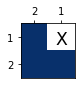

In [28]:
puzzle2x2 = Puzzle(clues2x2)
board2x2 = Board(puzzle2x2)
plotter2x2 = BoardPlotter(puzzle2x2)
board2x2.fill_all(solution2x2)
plotter2x2.show(board2x2)

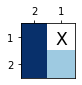

In [29]:
# not complete
puzzle2x2 = Puzzle(clues2x2)
board2x2 = Board(puzzle2x2)
plotter2x2 = BoardPlotter(puzzle2x2)

board2x2.mark(0, 0, BoardMark.BLACK) 
board2x2.mark(0, 1, BoardMark.FILLER) 
board2x2.mark(1, 0, BoardMark.BLACK) 

assert board2x2.count_empty() > 0
plotter2x2.show(board2x2)

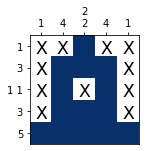

In [30]:
puzzle5x5s = Puzzle(clues5x5s)
board5x5s = Board(puzzle5x5s)
plotter5x5s = BoardPlotter(puzzle5x5s)

board5x5s.fill_all(solution5x5s)
plotter5x5s.show(board5x5s)

# 5. Wrap up

We have learned
- groupby

The class and solutions are saved in episode04.py.


5.1. Quick test of saved classes

In [31]:
# reset all variables from tests
%reset -f

In [33]:
from episode01 import clues2x2, clues5x5s, Board, BoardMark
from episode02 import solution2x2, solution5x5s, GameEngine
from episode03b import Puzzle, Board, BoardMark, BoardPlotter

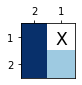

In [34]:
puzzle2x2 = Puzzle(clues2x2)
assert puzzle2x2.is_consistent()

board2x2 = Board(puzzle2x2)
plotter2x2 = BoardPlotter(puzzle2x2)

board2x2.mark(0, 0, BoardMark.BLACK) 
board2x2.mark(0, 1, BoardMark.FILLER) 
board2x2.mark(1, 0, BoardMark.BLACK) 

assert board2x2.count_empty() == 1
plotter2x2.show(board2x2)